In [28]:
import os
os.environ['USE_PYGEOS'] = '0'


import geopandas as gpd

from  fiona import listlayers
#link con los mapas 
canadaMapsLink="https://github.com/AnaLuciaChamorro/geoCanadadf/raw/main/maps/countryMaps.gpkg"

#layers in maps
listlayers(canadaMapsLink)

['provinces', 'cities', 'rivers', 'lakes', 'road']

In [54]:
canadaAirportsLink="https://github.com/AnaLuciaChamorro/gdfCanada/raw/main/maps/airports_3347.gpkg"
listlayers(canadaAirportsLink)

['airports']

In [55]:
#leemos la data de los layers
airports=gpd.read_file(canadaAirportsLink,layer='airports')
rivers=gpd.read_file(canadaMapsLink,layer='rivers')
provinces=gpd.read_file(canadaMapsLink,layer='provinces')

In [56]:
import pandas as pd 
infoseaports=pd.read_csv(os.path.join("data","UpdatedPub150.csv"))

#columns available (so many)
infoseaports.columns.to_list()

['World Port Index Number',
 'Region Name',
 'Main Port Name',
 'Alternate Port Name',
 'UN/LOCODE',
 'Country Code',
 'World Water Body',
 'IHO S-130 Sea Area',
 'Sailing Direction or Publication',
 'Publication Link',
 'Standard Nautical Chart',
 'IHO S-57 Electronic Navigational Chart',
 'IHO S-101 Electronic Navigational Chart',
 'Digital Nautical Chart',
 'Tidal Range (m)',
 'Entrance Width (m)',
 'Channel Depth (m)',
 'Anchorage Depth (m)',
 'Cargo Pier Depth (m)',
 'Oil Terminal Depth (m)',
 'Liquified Natural Gas Terminal Depth (m)',
 'Maximum Vessel Length (m)',
 'Maximum Vessel Beam (m)',
 'Maximum Vessel Draft (m)',
 'Offshore Maximum Vessel Length (m)',
 'Offshore Maximum Vessel Beam (m)',
 'Offshore Maximum Vessel Draft (m)',
 'Harbor Size',
 'Harbor Type',
 'Harbor Use',
 'Shelter Afforded',
 'Entrance Restriction - Tide',
 'Entrance Restriction - Heavy Swell',
 'Entrance Restriction - Ice',
 'Entrance Restriction - Other',
 'Overhead Limits',
 'Underkeel Clearance Manage

In [57]:
#renombramos el nombre de los puertos
infoseaports.rename(columns={'Main Port Name':'portName'},inplace=True)
#seleccionamos solo las columnas con las que nos quedaremos
infoseaports=infoseaports.loc[:,['portName', 'Country Code','Latitude', 'Longitude']]
infoseaports.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3774 entries, 0 to 3773
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   portName      3774 non-null   object 
 1   Country Code  3774 non-null   object 
 2   Latitude      3774 non-null   float64
 3   Longitude     3774 non-null   float64
dtypes: float64(2), object(2)
memory usage: 118.1+ KB


In [58]:
#verificamos que las capas tengan el mismo crs
provinces.crs.to_epsg()==airports.crs.to_epsg()==rivers.crs.to_epsg()

False

In [59]:
#identificamos que crs es el discordante
provinces.crs.to_epsg(),airports.crs.to_epsg(),rivers.crs.to_epsg()

(4326, 3347, 4326)

In [60]:
#cambiamos el crs de las provincias y ríos
rivers=rivers.to_crs(3347)
provinces=provinces.to_crs(3347)

In [61]:
provinces.crs.to_epsg()==airports.crs.to_epsg()==rivers.crs.to_epsg()

True

In [62]:
seaports=gpd.GeoDataFrame(data=infoseaports.copy(),
                 geometry=gpd.points_from_xy(infoseaports.Longitude,
                                             infoseaports.Latitude), 
                 crs=4326)#no está proyectado

seaports_canada=seaports[seaports['Country Code']=='Canada'].copy()

seaports_canada.reset_index(drop=True, inplace=True)
#proyectamos con el crs de Canada
seaports_canada_3347=seaports_canada.to_crs(3347) 

<Axes: >

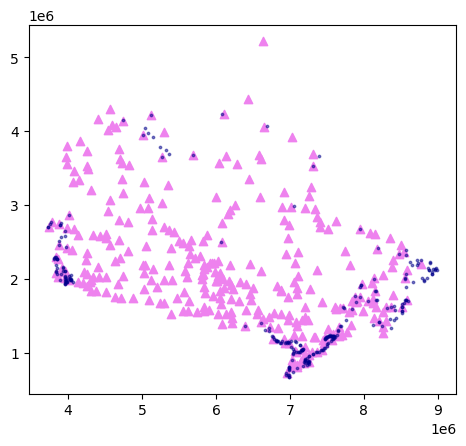

In [63]:
# seleccionamos el subconjunto de los aeropuertos medianos
mediumAirports=airports[airports.kind=='medium_airport'] 
mediumAirports.reset_index(drop=True, inplace=True)

#ploteamos
base=mediumAirports.plot(color='violet',marker="^")
seaports_canada_3347.plot(color='darkblue',ax=base,alpha=0.5,markersize=3)

In [64]:
#puertos
seaports_canada_3347.head()

,portName,Country Code,Latitude,Longitude,geometry
0,Port Severn,Canada,44.800000,-79.716667,POINT (7173072.050 1051169.583)
1,Little Bras D Or,Canada,46.250000,-60.300000,POINT (8562542.390 1720093.723)
2,Hilton,Canada,46.250000,-83.883333,POINT (6821112.908 1160542.204)
3,Kagawong,Canada,45.916667,-82.250000,POINT (6952950.534 1141032.855)
4,Douglastown,Canada,48.766667,-64.383333,POINT (8159882.288 1833159.695)


In [65]:
#aeropuertos medianos
mediumAirports.head()

,name,kind,latitude_deg,longitude_deg,elevation_ft,region_name,municipality,geometry
0,Billy Bishop Toronto City Centre Airport,medium_airport,43.627499,-79.396202,252.0,Ontario,Toronto,POINT (7224333.646 925621.026)
1,London Airport,medium_airport,43.035599,-81.153900,912.0,Ontario,London,POINT (7092745.018 832780.612)
2,John C. Munro Hamilton International Airport,medium_airport,43.173599,-79.934998,780.0,Ontario,Hamilton,POINT (7190253.037 866321.421)
3,Regina International Airport,medium_airport,50.431900,-104.666000,1894.0,Saskatchewan,Regina,POINT (5301503.877 1678527.853)
4,Kelowna International Airport,medium_airport,49.956100,-119.377998,1421.0,British Columbia,Kelowna,POINT (4293620.839 1953961.073)


In [66]:
# distancia entre 'Billy Bishop Toronto City Centre Airport' and 'Port Severn' en km
mediumAirports.iloc[0].geometry.distance(seaports_canada_3347.iloc[0].geometry)/1000
#dividimos entre 1000 porque inicialmente está en m

135.6104388383299

In [67]:
#try 1
seaports_canada_3347.geometry.apply\
(lambda g: mediumAirports.geometry.distance(g)/1000)

,0,1,2,3,4,5,6,7,8,9,...,319,320,321,322,323,324,325,326,327,328
0,135.610439,232.693306,185.644901,1973.916368,3017.659979,2141.372100,261.199449,161.389172,463.675998,843.923902,...,672.827721,2015.704293,3784.172680,3363.392908,3117.863858,1905.057341,3449.642045,1052.304577,1695.562604,1912.434716
1,1556.274240,1716.866003,1616.200857,3261.303406,4275.322811,3361.682116,1316.679831,1639.264816,1078.431202,2202.901525,...,1942.228546,2826.132876,4637.212995,4173.577661,3876.283103,1730.707444,4706.769212,2364.522918,2775.432149,2905.497660
2,466.663608,425.689634,472.049048,1605.465895,2649.099783,1775.230503,624.405659,423.183645,774.789325,477.295214,...,350.191394,1716.860673,3447.136013,3036.328153,2802.307151,1862.786618,3081.113145,687.472114,1352.659085,1579.602875
3,346.483837,338.470004,363.013567,1736.714407,2780.806845,1903.657619,491.301072,316.504561,647.197217,606.180289,...,447.592670,1808.547188,3558.498158,3142.616415,2902.944422,1849.262280,3213.131021,814.672009,1466.168947,1687.923523
4,1303.410026,1462.716741,1369.290741,2862.557972,3868.148208,2955.079293,1073.880754,1382.113192,812.717891,1832.464993,...,1567.255831,2408.296538,4222.073149,3759.187349,3463.343130,1382.287815,4298.337480,1981.635666,2362.893231,2488.739756
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
257,3588.511548,3499.102925,3577.397992,1524.956305,484.154694,1377.426067,3750.307427,3528.807083,3844.819908,2656.793790,...,2870.866972,2069.754129,1394.799545,1484.039556,1655.063581,3580.873591,120.207673,2453.449910,1957.771472,1865.284028
258,3663.313909,3578.774374,3654.619321,1598.656539,579.921832,1434.753308,3818.709279,3605.752194,3904.458356,2726.295561,...,2932.406230,2066.250078,1262.169996,1381.524595,1572.042886,3573.597409,270.254692,2520.231889,1993.598904,1883.706909
259,3622.416124,3534.222113,3611.912607,1557.983724,521.145783,1405.944139,3782.590220,3563.246252,3874.814932,2689.178617,...,2901.207513,2081.182897,1360.793896,1462.151750,1640.320626,3591.639099,165.561818,2485.071606,1980.714667,1883.142990
260,3638.183724,3552.926509,3629.132640,1573.300311,550.793529,1411.769382,3794.556670,3580.301961,3881.685737,2701.852514,...,2909.223195,2054.408365,1282.371709,1392.329529,1577.737985,3562.869328,241.234295,2496.166581,1974.440831,1867.606961


In [69]:
duplicates = seaports_canada_3347[seaports_canada_3347['portName'].duplicated(keep=False)]
print(duplicates['portName'])

124    Windsor
202    Windsor
Name: portName, dtype: object


In [72]:
duplicates = seaports_canada_3347[seaports_canada_3347['portName'].duplicated(keep=False)]
seaports_canada_3347.loc[duplicates.index[0], 'portName'] = 'NuevoNombre'

In [73]:
# try 2
seaports_canada_3347.set_index('portName').geometry.apply\
(lambda g: mediumAirports.set_index('name').geometry.distance(g)/1000)

InvalidIndexError: Reindexing only valid with uniquely valued Index objects

In [46]:
#try 3
seaports_canada_3347.set_index('portName').geometry.apply\
(lambda g: mediumAirports.set_index('name').geometry.distance(g)/1000).\
sort_index(axis=0).sort_index(axis=1)

InvalidIndexError: Reindexing only valid with uniquely valued Index objects